In [1]:

from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
import pandas as pd
import jax.numpy as jnp
import numpyro
     

In [2]:
df = pd.read_csv('../../data/MMM.csv')
df.head()

# Ya tenemos los datos agregados

,Calendar_Week,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales,is_peak_season
0,2018-01-06,11247,11214,16934,1.846363e+07,3694309,995533,16447,2961900,0
1,2018-01-13,15453,12580,12548,2.670896e+07,626000,983495,17111,3043768,0
2,2018-01-20,12759,13145,14895,2.265773e+07,2304353,1234005,11919,2967530,0
3,2018-01-27,10709,15208,13324,2.204346e+07,3575722,814181,13857,3359958,0
4,2018-02-03,13416,15129,12932,2.154114e+07,2008599,636301,16783,3156423,0


In [3]:
SEED = 105
# media vars
mdsp_cols = ["Paid_Views", "Google_Impressions", "Email_Impressions", "Facebook_Impressions", "Affiliate_Impressions"]
sales_cols =['Sales']



data_size = len(df)

n_media_channels = len(mdsp_cols)
media_data = df[mdsp_cols].to_numpy()
target = df['Sales'].to_numpy()
extra_features = df['is_peak_season'].to_numpy()
costs = df[mdsp_cols].sum().to_numpy()

In [4]:
print(costs)

[4.60516160e+07 2.70371636e+09 2.32031411e+09 8.21106135e+08
 6.99011640e+07]


In [5]:
# Split and scale data.
test_data_period_size = 0
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
media_data_test = media_data[split_point:, ...]
# Target
target_train = target[:split_point]
target_test = target[split_point:]

In [6]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
target_train = target_scaler.fit_transform(target_train)
#extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
costs = cost_scaler.fit_transform(costs)

In [7]:
print("Media Prior:", costs)

Media Prior: [0.03862684 2.2678037  1.9462163  0.6887215  0.0586312 ]


In [8]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

# Evidencia bayesiana

In [9]:
import numpy as np


if extra_features_train.ndim == 1:
    extra_features_test = extra_features_test[:, np.newaxis]
    extra_features_train = extra_features_train[:, np.newaxis] 

In [10]:
# from sklearn.metrics import mean_absolute_percentage_error


# adstock_models = ["adstock", "hill_adstock", "carryover"]
# degrees_season = [1,2,3]


# for model_name in adstock_models:
#     for degrees in degrees_season:
#         mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
#         mmm.fit(media=media_data_train,
#                 media_prior=costs,
#                 target=target_train,
#                 extra_features=extra_features_train,
#                 number_warmup=1000,
#                 number_samples=1000,
#                 number_chains=1,
#                 degrees_seasonality=degrees,
#                 weekday_seasonality=True,
#                 seasonality_frequency=365,
#                 seed=1)
        
#         prediction = mmm.predict(
#         media=media_data_test,
#         extra_features=extra_features_test,
#         target_scaler=target_scaler)
#         p = prediction.mean(axis=0)

#         mape = mean_absolute_percentage_error(target_test, p)
#         print(f"model_name={model_name} degrees={degrees} MAPE={mape} samples={p[:3]}")

Analysis of Your Results:
Adstock Model:

Degrees 1: MAPE = 11,731,637.286 

Degrees 2: MAPE = 11,016,277.033 

Degrees 3: MAPE = 10,978,006.970 

Hill Adstock Model:

Degrees 1: MAPE = 4.159 

Degrees 2: MAPE = 4.094 

Degrees 3: MAPE = 4.066 

Carryover Model:

Degrees 1: MAPE = 10,540,823.758 

Degrees 2: MAPE = 10,134,689.067 

Degrees 3: MAPE = 10,224,481.761 


In [11]:
number_warmup=1000
number_samples=1000

In [12]:
mmm.fit(
    media=media_data_train,
    degrees_seasonality=3,
    media_prior=costs,
    extra_features=extra_features_train,
    target=target_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    media_names = mdsp_cols,
    seed=SEED)

c:\Users\gomez\anaconda3\envs\tfm\lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:11<00:00, 172.43it/s, 127 steps of size 2.30e-02. acc. prob=0.95]


In [13]:
mmm.print_summary()

# Bajando el target accept
# Los priors pueden estar cerrados



                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.00      0.16      0.00     -0.25      0.27   1024.23      1.00
                      coef_media[0]      0.03      0.02      0.03      0.00      0.06   2172.86      1.00
                      coef_media[1]      4.26      1.11      4.13      2.36      5.82    715.54      1.00
                      coef_media[2]      0.70      0.56      0.59      0.00      1.38   1200.81      1.00
                      coef_media[3]      0.56      0.30      0.53      0.05      1.01   1248.10      1.00
                      coef_media[4]      0.05      0.04      0.04      0.00      0.10   2026.64      1.00
                      coef_trend[0]     -0.01      0.01     -0.01     -0.03      0.00    632.17      1.00
                         expo_trend      0.66      0.15      0.62      0.50      0.88    821.55      1.00
             gamma_seasonality[0,0]     -0.11

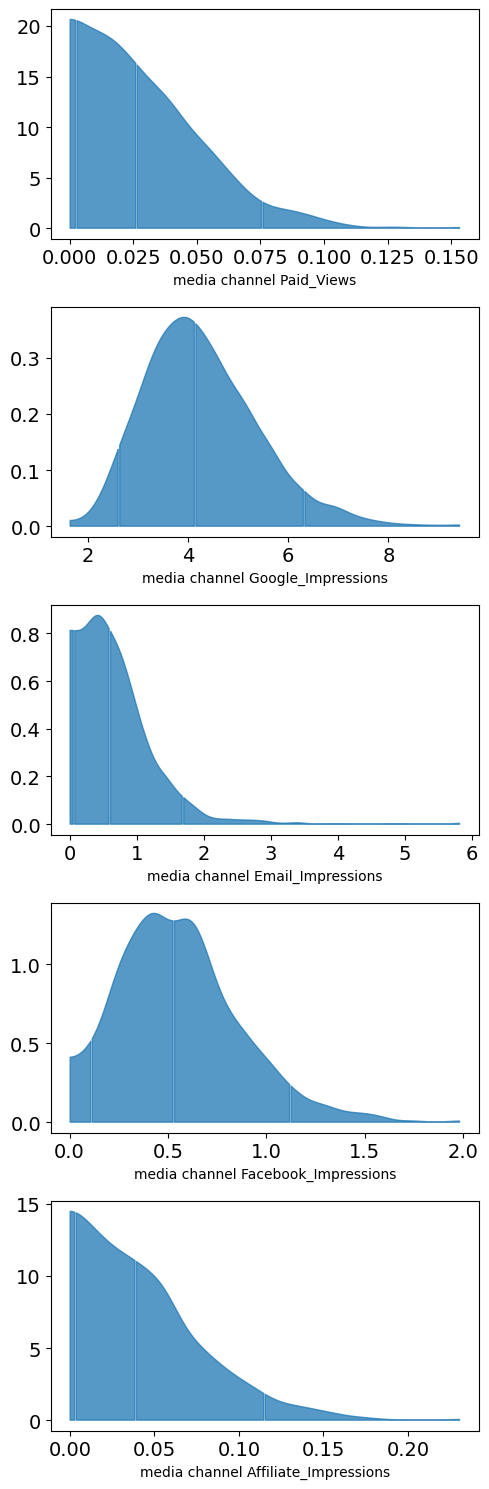

In [14]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=mdsp_cols)


In [15]:
#plot.plot_prior_and_posterior(media_mix_model=mmm)

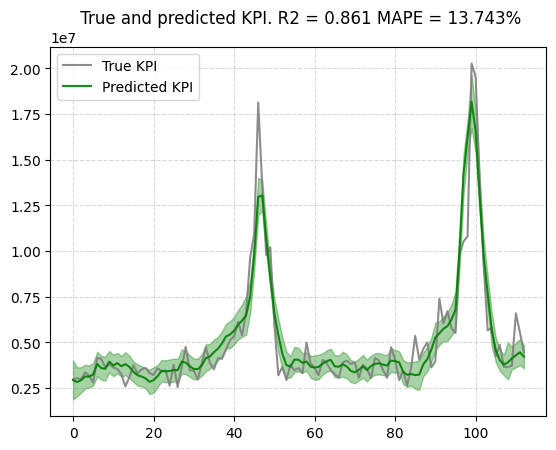

In [16]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)


In [17]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              seed=SEED)
new_predictions.shape

(2000, 0)

In [18]:
# plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
#                                  out_of_sample_target=target_scaler.transform(target[split_point:]))

In [19]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

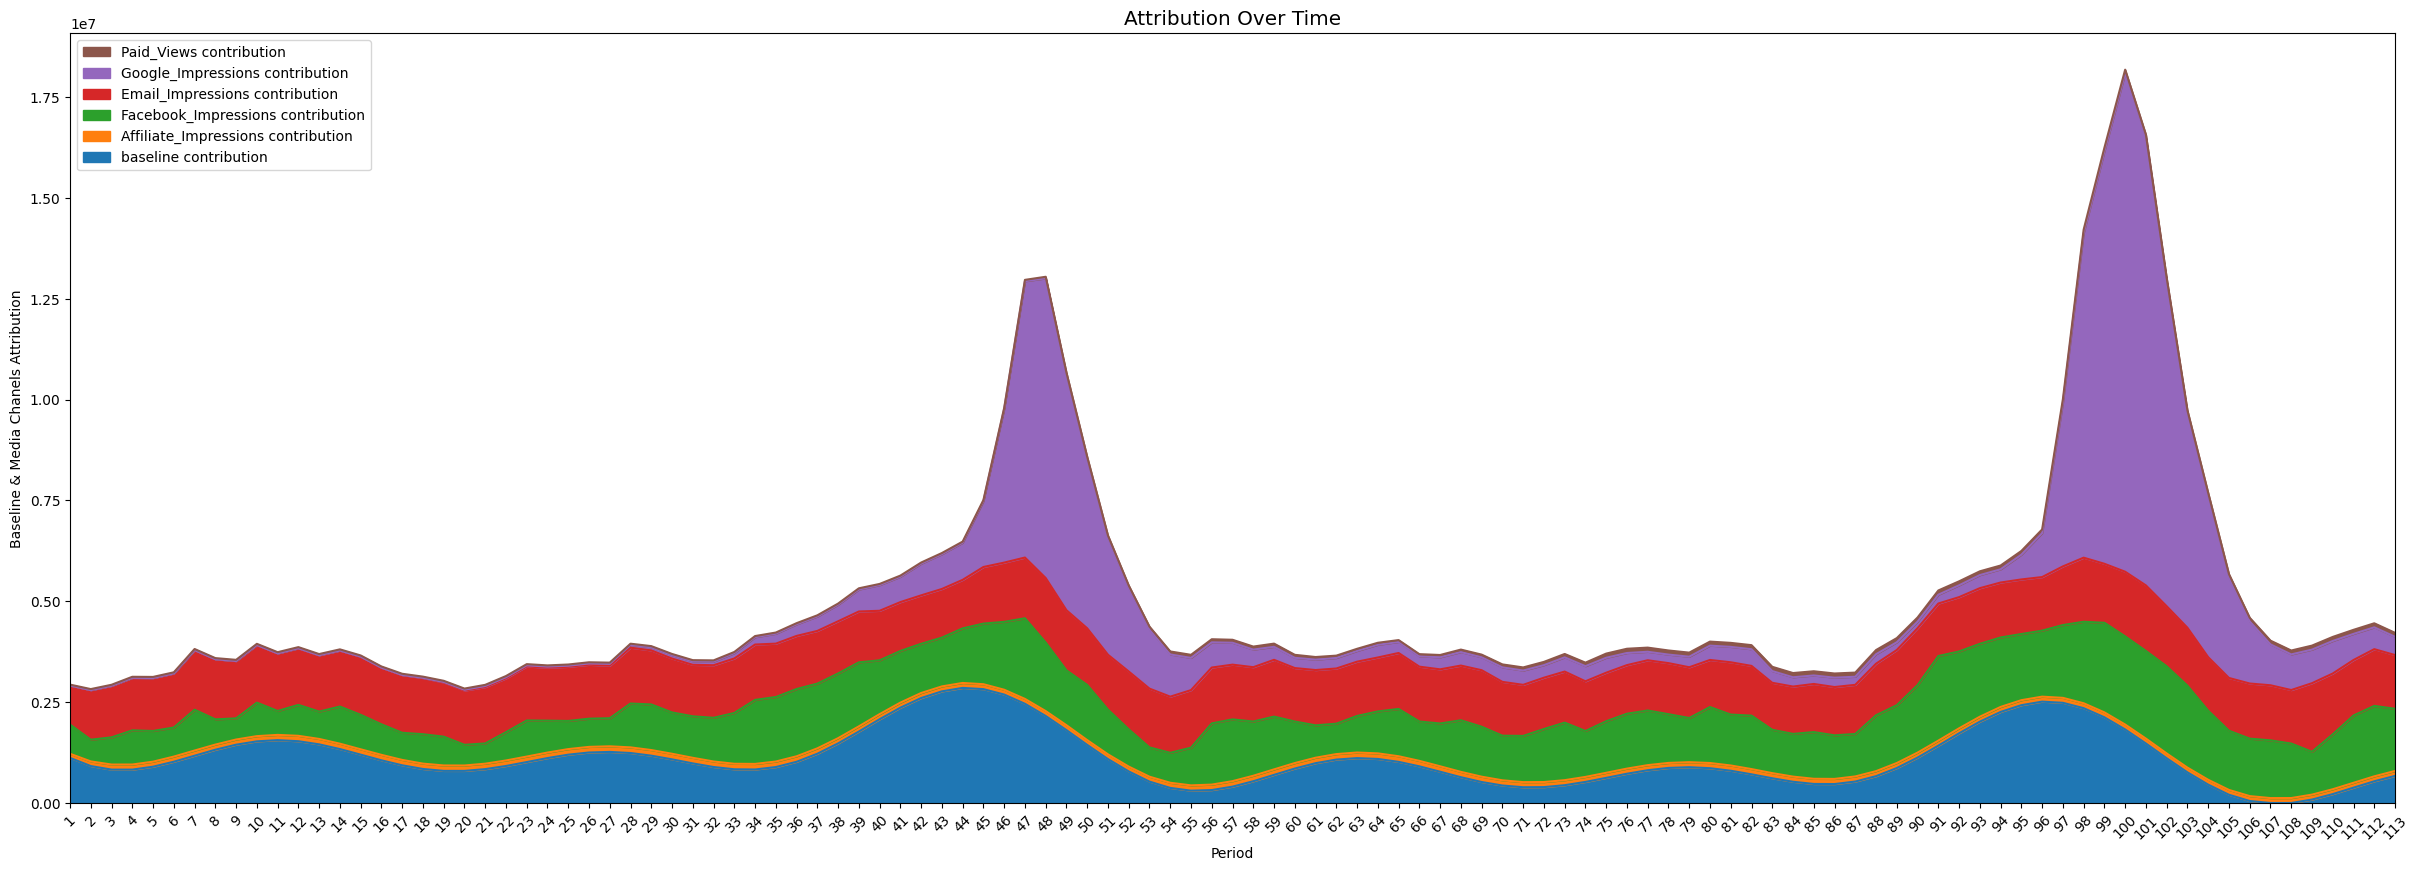

In [20]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = mdsp_cols
                                                )

# Baesline contr == brand equity

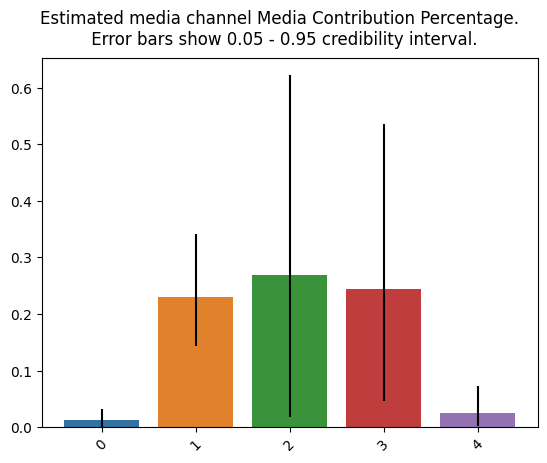

In [21]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")


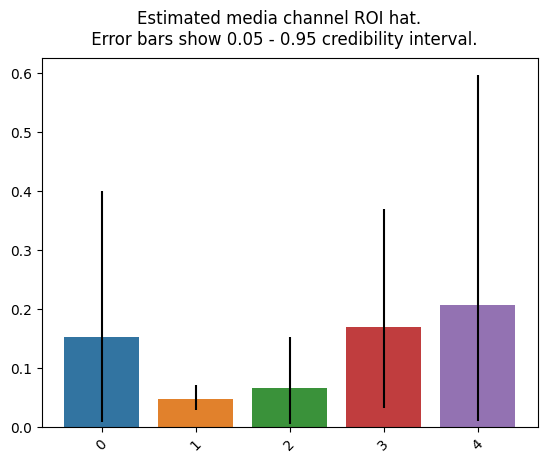

In [22]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")


# Optim

In [48]:
prices = jnp.ones(mmm.n_media_channels)

n_time_periods = 10
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods


In [49]:
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -40859399.6362185
            Iterations: 66
            Function evaluations: 755
            Gradient evaluations: 65


In [50]:
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([3.2602915e+06, 2.6785387e+08, 1.6427002e+08, 8.7197120e+07,
       4.9487555e+06], dtype=float32)

In [51]:
# Ambos valores deben ser practicamente iguales

previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([4.0753645e+06, 2.3926694e+08, 2.0533752e+08, 7.2664264e+07,
       6.1859435e+06], dtype=float32)

In [52]:
budget, optimal_buget_allocation.sum()

(Array(5.2753005e+08, dtype=float32), Array(5.2753005e+08, dtype=float32))

In [53]:
budget, jnp.sum(solution.x * prices)


(Array(5.2753005e+08, dtype=float32), Array(5.2753005e+08, dtype=float32))

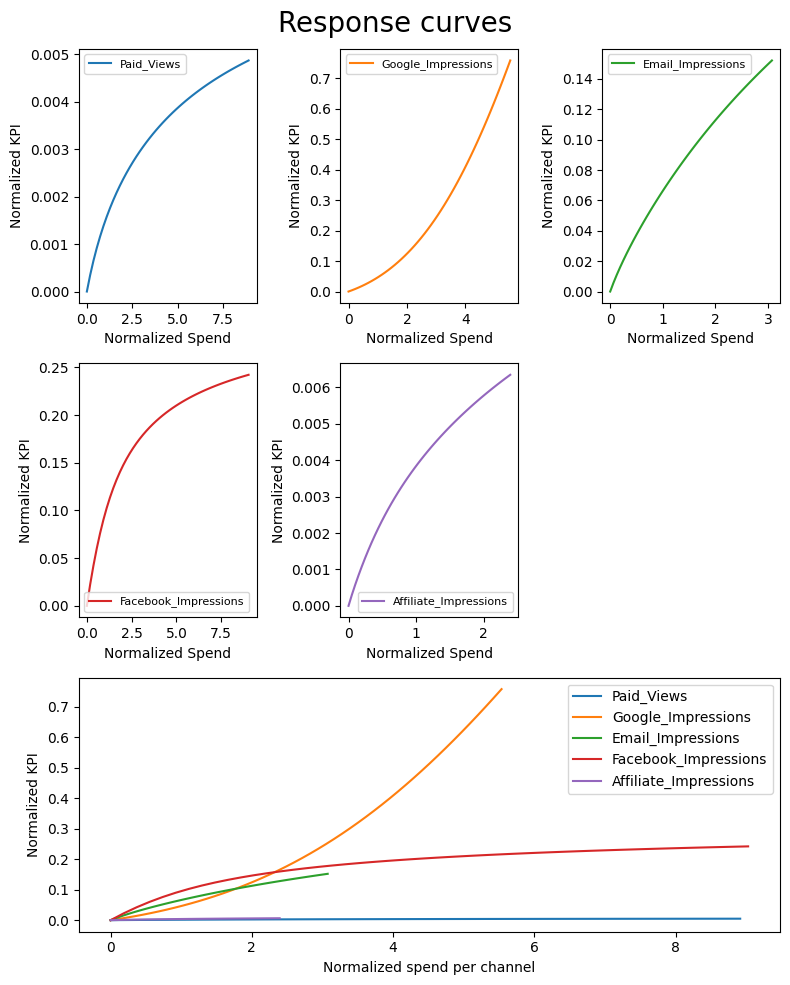

In [54]:

# Calculate the average spend for each media channel
average_spend = df[mdsp_cols].mean().to_numpy()


if media_scaler is not None:
    average_spend = media_scaler.inverse_transform(average_spend.reshape(1, -1))[0]

plot.plot_response_curves(
    media_mix_model=mmm

)

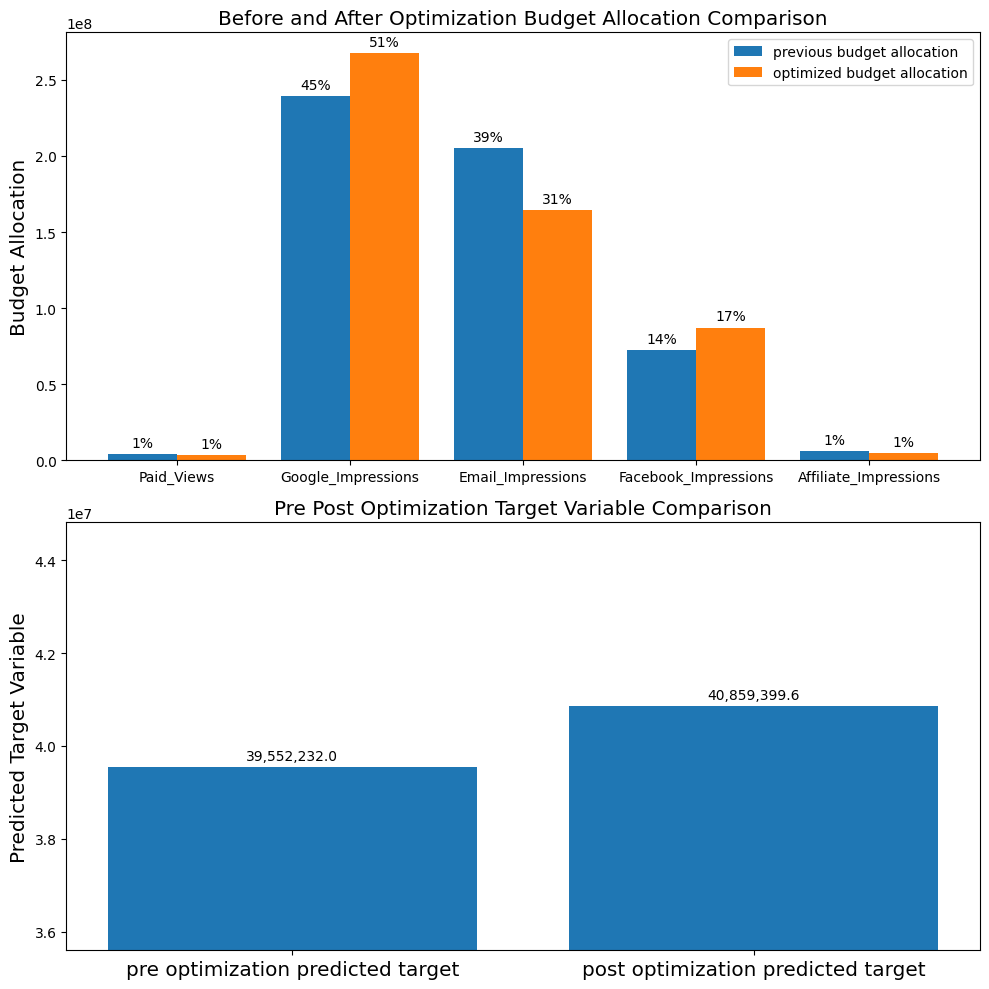

In [55]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))

In [31]:
# Guardamos el modelo en disco
file_path = "media_mix_model.pkl"
utils.save_model(mmm, file_path)